Groundwater | Case Study

# Topic 1 : Introduction to the Groundwater course - The Limmat Vally Aquifer 

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noel du Prat

In [1]:
# Setting up the notebook
import sys
import os

from IPython.display import display

# Load local modules
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')
import climate_utils as cu
import print_images as du

# Introducing The Case Study
Most exercises as well as the final project in this course are based on case studies. Case studies are real-world scenarios that provide you with an opportunity to apply your knowledge and skills to solve complex groundwater problems. In this first year we choose the Limmat valley aquifer in Zurich, Switzerland. 

We will follow the actual steps a professional groundwater modeler might take to set up a numerical model to answer a specific question. In a first step, the modelers familiarize themselves with the Limmat valley aquifer and its hydrological and hydrogeological properties. We start out with a very generic perceptual model of the aquifer (see Figure 1), which we'll refine as we uncover new information. 

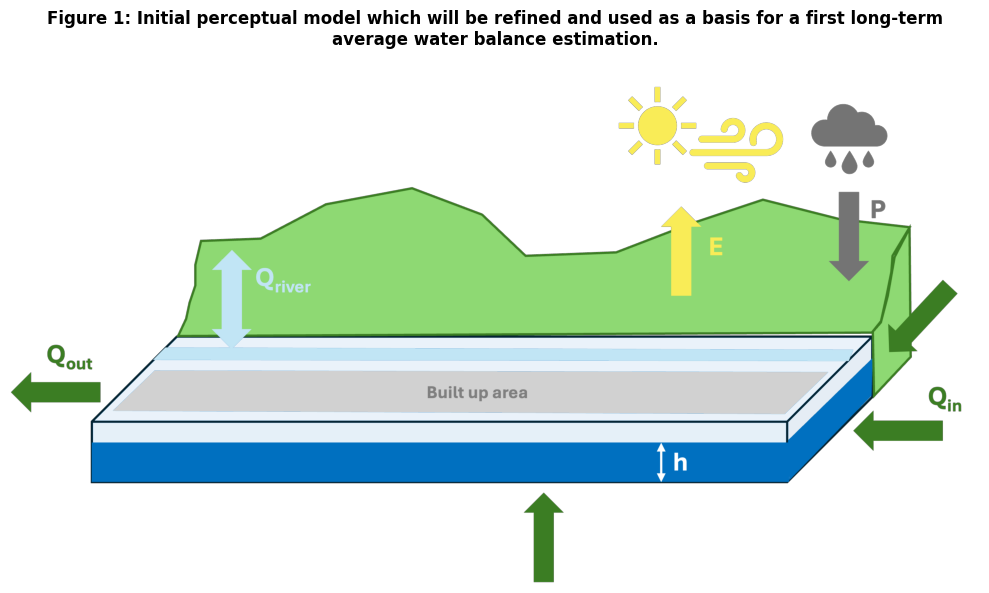

In [2]:
du.display_image(
    image_filename='perceptual_model_00_initial.png', 
    image_folder='1_perceptual_model', 
    caption='Figure 1: Initial perceptual model which will be refined and used as a basis for a first long-term average water balance estimation.'
)

We first try to get an understanding of the hydrogeology of the Limmat valley aquifer.  

# The Limmat Valley Aquifer
The Limmat valley aquifer is a well-studied groundwater reservoir beneath the city of Zurich, Switzerland. Doppler and colleagues write, that it was formed during the last ice age, when the Lindt glacier retreated. The Limmat valley aquifer has no direct hydraulic connection to lake Zurich in the east where it is bound by impermeable lake sediments and moraine material. The aquifer is further confined in the north and south by the side morains of the Lindth glacier. Lateral inflow of groundwater from the hills in the north and south is to be expected. The groundwater body is further in connection with the river Sihl in the east and the river Limmat in the north. The hydraulic properties of the aquifer are higly heterogenic because of its complex geological history formed through various sedimentation and erosion events from the rivers Sihl and Limmat. [\[1, 2\]](#references)

In Figure 2 you see a prinscreen of the [GIS-browser](https://www.gis.zh.ch/) of the canton of Zurich. The cyanide blue area in the center of the map shows the Limmat valley aquifer. The darker the color, the larger the thickness of the aquifer.  

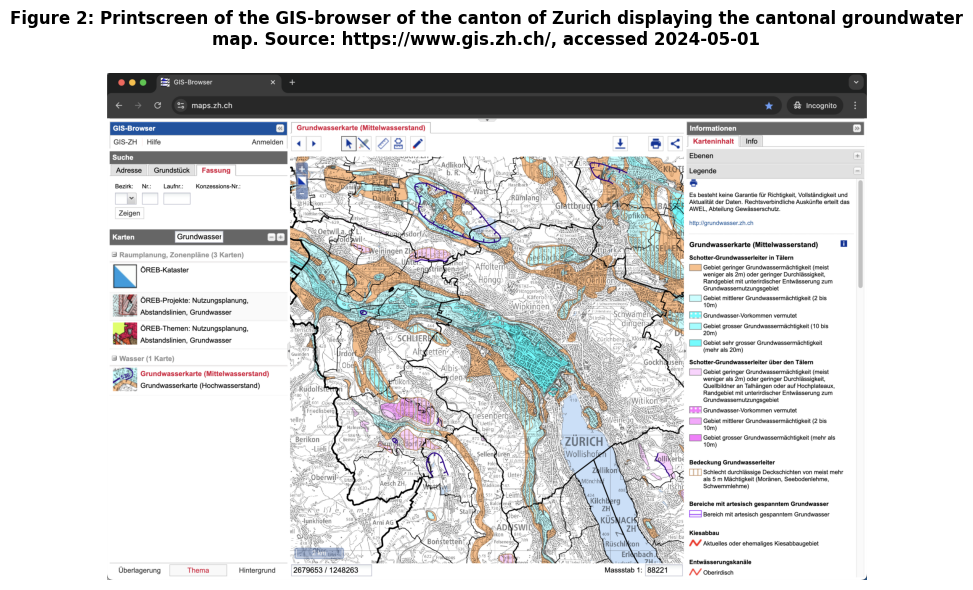

In [3]:
du.display_image(
    image_filename='GIS-browser_canton_Zurich.png', 
    image_folder='1_perceptual_model',
    caption='Figure 2: Printscreen of the GIS-browser of the canton of Zurich displaying the cantonal groundwater map. Source: https://www.gis.zh.ch/, accessed 2024-05-01'
)

We now have an understanding of the geometry of the aquifer. Let's simplify update our perceptual model with the information we have gathered so far: 

- The aquifer does not have a direct hydraulic connection to lake Zurich in the east. 
- It is probably heavily influenced by the river Sihl in the east and the river Limmat in the north.
- Since groundwater flow in river valleys generally follows the topography, we can assume that the groundwater flow in the Limmat valley aquifer is directed from south-east to west.
- The aquifer thickness is highly variable. To adequately represent the known geometry of the aquifer, a 3D model with a high spatial resolution is required. Since such a resolution would not be computationally feasible on JupyterHub, we will opt for a 2D model with a simplified geometry for the case study work. 
- The simplified geometry will show a larger thickness in the south-east with a gradual thinning towards the west. The thickness will be represented by a single layer with a variable thickness. We will use the thickness values from the GIS-browser to define the thickness of the aquifer in our model whereby we will have to map the isolines of groundwater thickness to the model grid (see Figure 3).
- The aquifer extends boyond the boundaries of the city of Zurich. Since we are intersted mainly in applying our numerical experiment in the city region, this means that we will have to make assumptions about the outflow boundary of the aquifer.

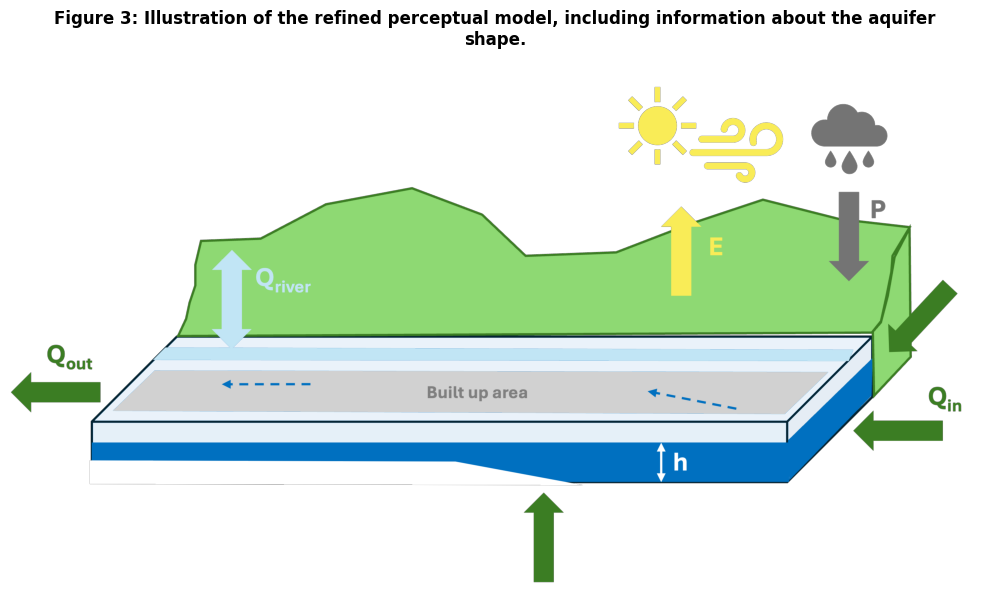

In [4]:
du.display_image(
    image_filename='perceptual_model_01_simple_geometry.png', 
    image_folder='1_perceptual_model',
    caption='Figure 3: Illustration of the refined perceptual model, including information about the aquifer shape.'
)

<div style="padding: 1em; margin: 1em 0; border-left: 3px solid #8e44ad; background-color: #f5eef8;">
<strong>🤔 Think about it:</strong><br>
Take a few minutes to explore the available layers in the GIS-browser of the canton of Zurich. What do you think are the most important layers for groundwater modeling? Why?
</div>

# Climate
We get climate data from the Swiss Federal Office of Meteorology and Climatology (MeteoSwiss). The data is available for download at the following link: [MeteoSwiss](https://www.meteoswiss.admin.ch/services-and-publications/applications/measurement-values-and-measuring-networks.html#param=messnetz-klima&table=false&station=SMA&compare=y&chart=year) and made available in the data directory of the zurich case study repository. [\[4\]](#references) 
The closest station to the Limmat valley aquifer is the Fluntern station. The data is available for the years 1991-2020. Let's have a look at the data. 

In [5]:
data_path = os.path.abspath(
    os.path.join('case_study_zurich', 'data', 'climate'))
# Test if this is a valid path
if not os.path.exists(data_path):
    print(f"Path {data_path} does not exist.")

climate_norms = cu.read_climate_data(data_path, station_string='Fluntern')

# Inspect the climate norms
display(climate_norms)

,shortname,longname,station,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,tnd00nm0,Monthly values Frost days (minimum lower than ...,Fluntern,18.9,16.4,8.9,2.2,0.0,0.0,0.0,0.0,0.0,1.0,7.0,17.5
1,tnd30xm0,Monthly values Hot days (maximum 30 degrees C ...,Fluntern,0.0,0.0,0.0,0.0,0.1,1.9,3.4,3.1,0.0,0.0,0.0,0.0
2,gre000m0,Monthly values Global radiation / watt/square ...,Fluntern,41.3,74.0,126.2,180.4,212.4,236.8,235.2,202.1,147.0,85.6,45.6,32.1
3,pva200m0,Monthly values Vapour pressure 2m / hectopasca...,Fluntern,5.6,5.6,6.6,7.8,10.8,13.6,15.1,15.5,12.9,10.4,7.5,6.0
4,rre150m0,Monthly values Precipitation total / millimete...,Fluntern,63.0,60.3,71.2,80.4,128.2,127.6,126.0,119.1,87.4,85.2,76.1,83.4
5,tre200m0,Monthly values Air temperature 2m / degree Cel...,Fluntern,0.9,1.8,5.8,9.6,13.6,17.1,19.0,18.6,14.4,10.0,4.9,1.7
6,tnd25xm0,Monthly values Summer days (maximum 25 degrees...,Fluntern,0.0,0.0,0.0,0.4,3.3,10.1,14.7,12.9,3.4,0.0,0.0,0.0
7,tre2dymx,Monthly values Mean maximum temperature 2m / d...,Fluntern,3.5,5.2,10.2,14.8,18.8,22.4,24.3,23.9,19.1,13.8,7.6,4.0
8,fkl010m0,Monthly values Wind speed scalar / meter/secon...,Fluntern,2.3,2.3,2.5,2.1,2.1,1.9,1.9,1.7,1.8,1.8,2.0,2.2
9,sremaxmv,Monthly values Relative sunshine duration / pe...,Fluntern,24.1,33.5,42.3,47.0,44.6,48.4,52.6,53.4,47.5,35.4,24.3,19.9


> **🤔 Think about it**  
> We are looking at the climate data mostly to get an idea about groundwater recharge. In an aquifer like the Limmat valley aquifer, which is located in a densely populated area, we have to consider that the recharge is not only influenced by the climate but also by human activities. What do you think are the most important human activities that influence groundwater recharge in this area?

Note that we not only have temperature and precipitation data but a wide range of other climate variables which we can use to calculate potential evaporation. However, since the Limmat valley aquifer is located in a built-up area, we will have to make some assumptions about the land use and the resulting potential evaporation. Approximately 80% to 90% of the upper boundary of the aquifer is built-up, with only a small fraction of the area being green space or railway tracks. According to Qui and colleagues, urban evaporation in Swiss climate can amount to about 20% of the precipitation[\[6\]](@references), that would be around 200 mm/year for the Limmat valley aquifer. We will use this value as a first approximation for the potential evaporation in our model. 

Figure 4 below shows the monthly average temperature and precipitation for the Fluntern station. 

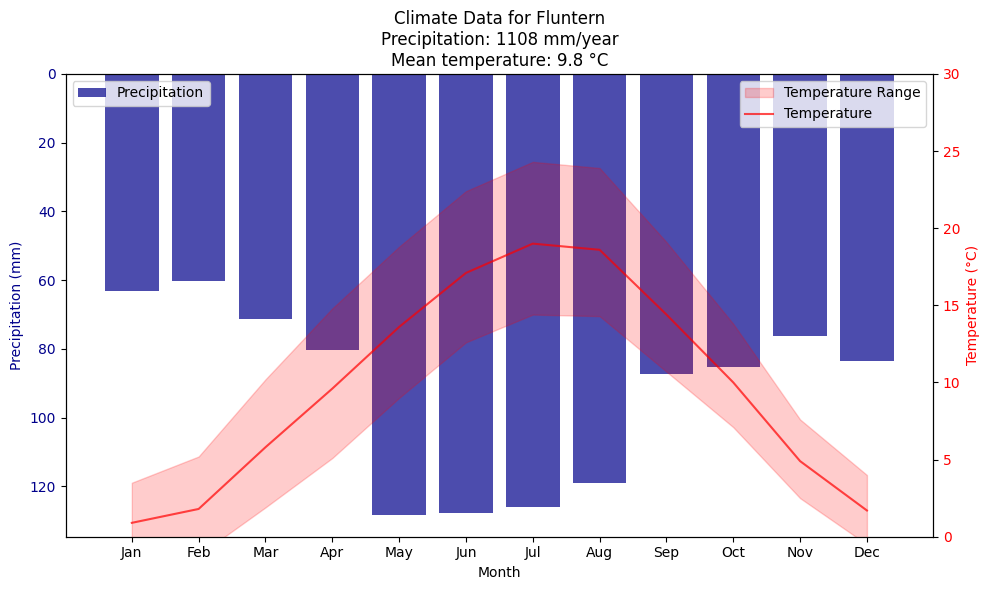

In [6]:
plt, fig = cu.plot_climate_data(climate_norms)
plt.show()

We now have first data concerning the fluxes into and out of the aquifer. We can now update our perceptual model with the information we have gathered so far:
- The average annual precipitation in the Limmat valley aquifer is 1108 mm/year. 
- We assume that the actual evaporation is about 20% of the precipitation, which would be around 200 mm/year (see Figure 5).
- The literature sugests that between 5% and 15% of the precipitation infiltrates into the aquifer [\[7\]](@references). We will use a value of 10% as a first approximation, which would be around 110 mm/year.
- The rest of the precipitation runs off, via the rainwater drainage system, into the river Sihl and the river Limmat. That would be about 70% of the precipitation, which would be around 770 mm/year.

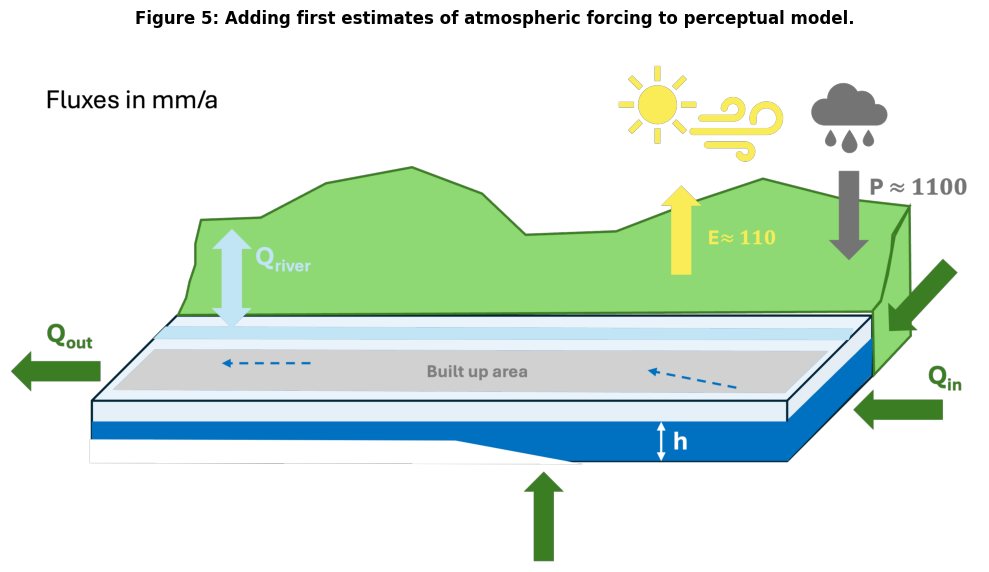

In [7]:
du.display_image(
    image_filename='perceptual_model_02_atmospheric_fluxes.png', 
    image_folder='1_perceptual_model',
    caption='Figure 5: Adding first estimates of atmospheric forcing to perceptual model.'
)

## River Discharge & River Water Levels
The federal office for the environment (FOEN) is the first address for hydrological data in Switzerland. You will find all surface water monitoring sites under [map.geo.admin.ch](https://map.geo.admin.ch) under layer *Hydrological gauaging stations* [\[5\]](#references) (see Figure 2). 

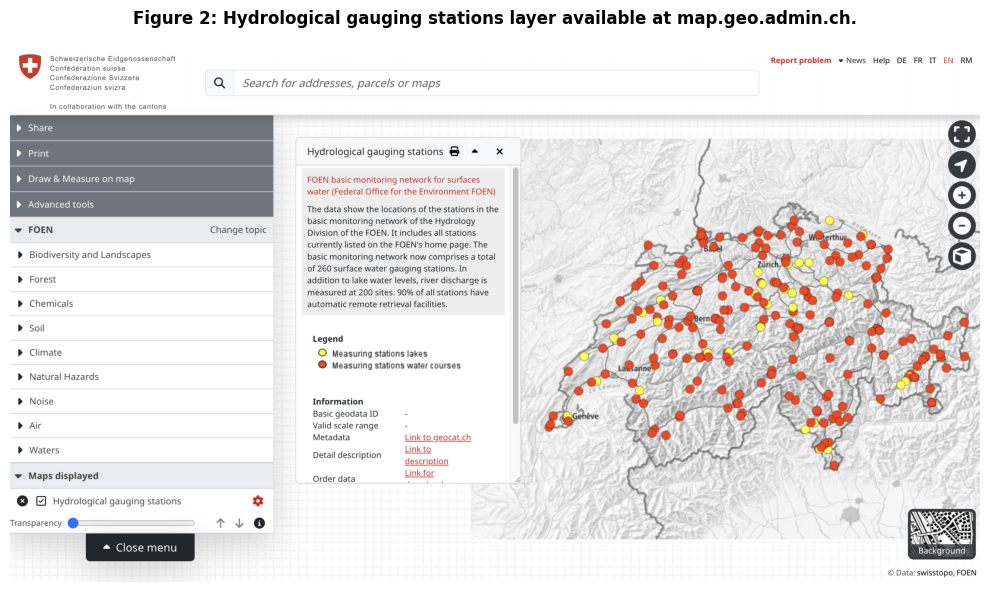

In [8]:
du.display_image(
    image_filename='BAFU_HydrologicalGaugingStations.png', 
    image_folder='1_perceptual_model',
    caption='Figure 2: Hydrological gauging stations layer available at map.geo.admin.ch.' 
)

When you zoom in to the Limmat valley aquifer (Figure 3), you will find the gauging stations of the rivers Sihl and Limmat. A next gauging station on the river Limmat is located at the city of Baden, downstream of a run-by-the-river hydropower plant, and therefore not relevant for our study. The gauging station on the river Sihl is located at the city of Zurich, upstream of the confluence with the river Limmat. The gauging station on the river Limmat is located at the city of Zurich, downstream of the confluence with the river Sihl. 

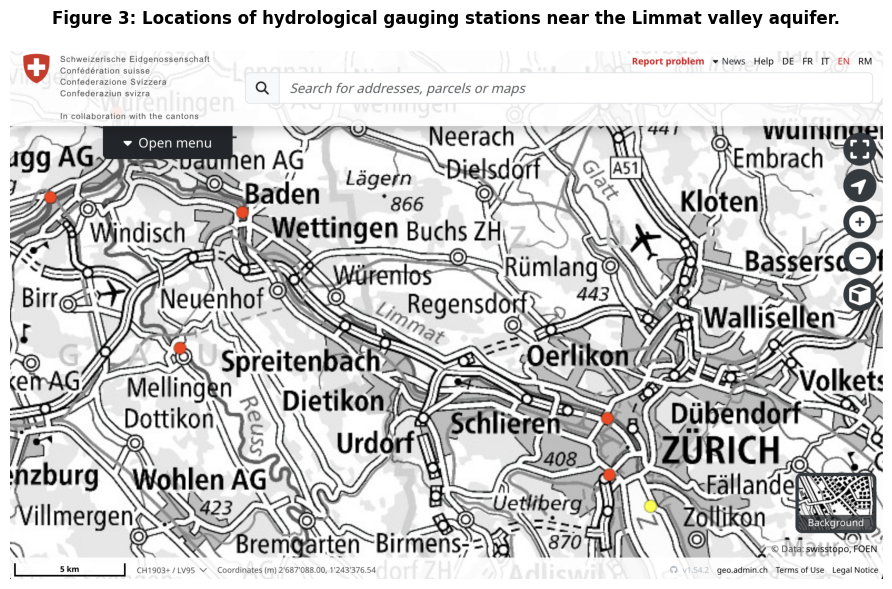

In [9]:
du.display_image(
    image_filename='BAFU_HydrologicalGaugingStations_closeup.png',
    image_folder='1_perceptual_model',
    caption='Figure 3: Locations of hydrological gauging stations near the Limmat valley aquifer.', 
)

A click on the gauaging station will bring you directly to the station site made available by the federal office for the environment (FOEN). The gauging station on the river Sihl is called [*Sihl - Zürich, Sihlhölzli*](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2176) and has ID 2176 and the gauging station on the river Limmat is called [*Limmat - Zürich, Unterhard*](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2099) and has ID 2099. The IDs are unique numeric station identifiers and typically required to retrieve data from data repositories or APIs. 

> **🤔 Think about it**  
> For surface water balancing, discharge is the important variable. However, when it comes to flooding or river-aquifer interaction, the water level is the more important variable. Why do you think that is?

From the station sites, we see current water levels, typically over the past 7 days but no water level dynamics. Thankfully, this data can be requested from FOEN.    
# TODO: Integrate water level data from FOEN, integrate once available.

No additional river gauging stations are maintained by the cantonal office for waste, water, energy and air (Amt für Abfall, Wasser, Energie und Luft (AWEL)) [\[6\]](#references). 


## Monitoring the Limmat Valley Aquifer
To get a first idea about the groundwater levels in the Limmat valley aquifer, we will have a look at the groundwater map.

Several authorities do groundwater monitoring in the Limmat valley aquifer. We will start with the federal office for the environment (FOEN) which maintains a network of groundwater observation wells. You find an overview over the available groundwater monitoring sites at [https://map.geo.admin.ch/](https://map.geo.admin.ch/) in layer *Groundwater level/spring discharge* [\[7\]](#references). One monitoring well maintained by FOEN is located in the Limmat valley aquifer but far downstream of our area of interest in the city center. Further, this well is a drinking water production well and can therefore not be used as an outflow boundary.  

Few groundwater observation wells are operated by the cantonal office of the environment (AWEL) (Figure 4).



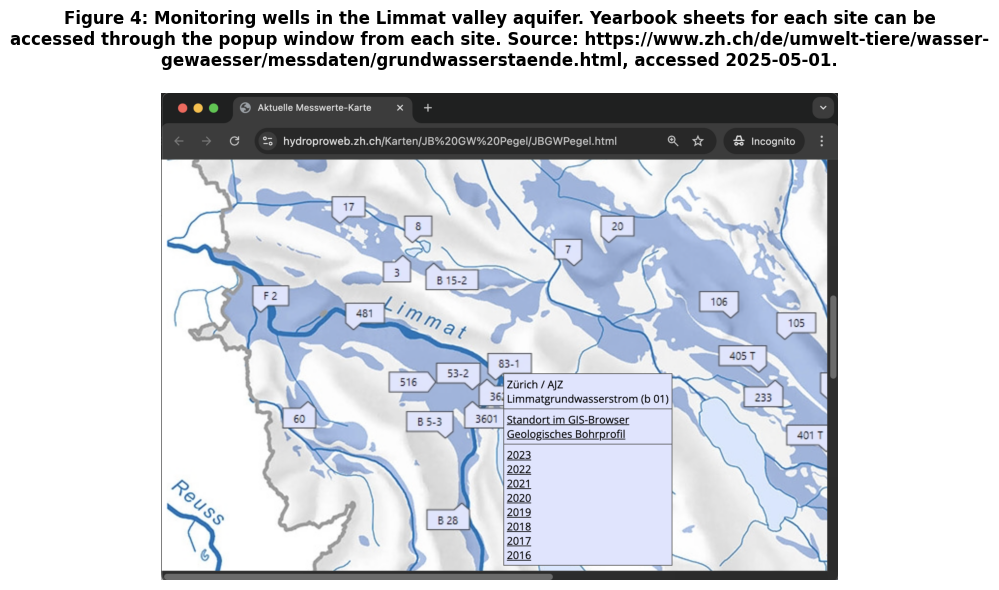

In [10]:
du.display_image(
    image_filename='GWmonitoring_locations_AWEL.png', 
    image_folder='1_perceptual_model',
    caption='Figure 4: Monitoring wells in the Limmat valley aquifer. Yearbook sheets for each site can be accessed through the popup window from each site. Source: https://www.zh.ch/de/umwelt-tiere/wasser-gewaesser/messdaten/grundwasserstaende.html, accessed 2025-05-01.'
)

> **🤔 Think about it**  
> What are the major hydrological processes in the Limmat valley aquifer?  
> Where would you set the boundaries of the Limmat valley aquifer?

# TODO: Finished perceptual model showing all fluxes

## References
[\[1\]](#the-limmat-valley-aquifer) Hug J., and Beilick, A. (1934): Die Grundwasserverhältnisse des Kantons Zürich. In: Beiträge zur Geologie der Schweiz - Geotechnische Serie - Hydrologie. German. Available online here: https://scnat.ch/de/uuid/i/0bd7aa3b-0bd7-5d54-9e2f-597a42dada50-Die_Grundwasserverh%C3%A4ltnisse_des_Kantons_Z%C3%BCrich (accessed 2025-05-01)   
[\[2\]](#the-limmat-valley-aquifer) Doppler, T., Hendricks Franssen, H.-J., Kaiser H.-P., Kuhlman U., Stauffer, F. (2007): Field evidence of a dynamic leakage coefficient for modelling river–aquifer interactions. Journal of Hydrology, Volume 347, Issues 1–2, DOI: https://doi.org/10.1016/j.jhydrol.2007.09.017.  
[\[3\]](#the-limmat-valley-aquifer) GIS-browser of the canton of Zurich: https://www.gis.zh.ch/ (accessed 2025-05-01)  
[\[4\]](#climate) MeteoSwiss: https://www.meteoswiss.admin.ch/services-and-publications/applications/measurement-values-and-measuring-networks.html#param=messnetz-klima&table=false&station=SMA&compare=y&chart=year (accessed 2025-05-01)  
[\[5\]](#climate) Burt, C. M., Mutziger, A. J., Allen, R. G., and Howell, T. A. (2005): Evaporation Research: Review and Interpretation. Journal of Irrigation and Drainage Engineering, 131(1), 1–13. DOI: [https://doi.org/10.1061/(ASCE)0733-9437(2005)131:1(1)](https://doi.org/10.1061/(ASCE)0733-9437(2005)131:1(1)).  
[\[6\]](#climate) Qui, Guo Yu, Yan, Chunhua, Liu, Yuanbo (2023): Urban evapotranspiration and its effects on water budget and energy balance: Review and perspectives. Earth-Science Reviews, Volume 246. DOI: [https://doi.org/10.1016/j.earscirev.2023.104577](https://doi.org/10.1016/j.earscirev.2023.104577)  
[\[7\]](#climate) Lerner, David N. (2002): Identifying and quantifying urban recharge: a review. Hydrogeology Journal, Volume 10, Issue 1, pp 143–152. DOI: [https://doi.org/10.1007/s10040-001-0177-7](https://doi.org/10.1007/s10040-001-0177-1)   
[\[5\]](#river-discharge) Locations of hydrological gauging stations maintained by the Federal Office for the Environment (FOEN): https://map.geo.admin.ch (accessed 2025-05-01)
[\[6\]](#river-discharge) Locations of hydrological gauging stations maintained by the cantonal office for waste, water, energy, and air (AWEL): https://www.zh.ch/de/umwelt-tiere/wasser-gewaesser/messdaten/abfluss-wasserstand.html (accessed 2025-05-01)  
[\[7\]](#monitoring-the-limmat-valley-aquifer) Locations of groundwater monitoring wells maintained by Federal Office for the Environment (FOEN): https://www.zh.ch/de/umwelt-und-natur/wasser/grundwasser/monitoring.html (accessed 2025-05-01)  
[\[8\]](#monitoring-the-limmat-valley-aquifer) Cantonal office of the environment (AWEL): https://www.zh.ch/de/umwelt-tiere/wasser-gewaesser/messdaten/grundwasserstaende.html (accessed 2025-05-01)
